In [1]:
!pip -q install rapidfuzz scikit-learn pandas numpy

In [2]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '8'

In [3]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

from rapidfuzz import fuzz, process


In [4]:
# ---------- Load Online Retail II ----------
retail_path = r"C:\Users\thapa\Desktop\project\Online retial II\online_retail_II.csv"
df = pd.read_csv(retail_path, encoding="ISO-8859-1")

print("Retail shape:", df.shape)
display(df.head())

# ---------- Load Company Names ----------
company_path = r"C:\Users\thapa\Desktop\project\Online retial II\company names\Company Names.csv"
companies = pd.read_csv(company_path)

print("Company shape:", companies.shape)
display(companies.head())


Retail shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Company shape: (9987, 7)


,Company Name,Rating,Review Count,Company Type,Headquarters,Company Age,Number of Employees
0,TCS,3.9,16.1k Reviews,Public,Mumbai + 156 more,52 years old,10000+ employees
1,Accenture,4.0,13.9k Reviews,Private,Dublin + 40 more,31 years old,10000+ employees
2,ICICI Bank,4.1,12.6k Reviews,Public,Mumbai + 42 more,26 years old,10000+ employees
3,Cognizant,3.9,12k Reviews,Private,Teaneck + 39 more,26 years old,10000+ employees
4,HDFC Bank,4.0,10.8k Reviews,Public,Mumbai + 46 more,26 years old,10000+ employees


In [5]:
df = df.copy()
df.columns = [c.strip() for c in df.columns]

# Fix column names (different Kaggle versions have different names)
# Most common:
# InvoiceNo, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country
rename_map = {
    "Invoice": "InvoiceNo",
    "CustomerID": "Customer ID",
    "UnitPrice": "Price"
}
for k, v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df.rename(columns={k: v}, inplace=True)

required_cols = ["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "Price", "Customer ID", "Country"]
missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)

df = df.dropna(subset=["InvoiceNo", "StockCode", "Description", "InvoiceDate", "Customer ID", "Country"])

# Remove cancelled invoices
df = df[df["InvoiceNo"].astype(str).str.startswith("C") == False]

# Datetime conversion
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Numeric conversions
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df = df.dropna(subset=["Quantity", "Price"])

# Total amount
df["Amount"] = df["Quantity"] * df["Price"]

# Keep positive transactions only
df = df[df["Amount"] > 0]

print("Cleaned Retail shape:", df.shape)
display(df.head())


Missing columns: []
Cleaned Retail shape: (805549, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [6]:
df["merchant_id"] = (
    df["Country"].astype(str).str.lower().str.strip() + "_" +
    df["StockCode"].astype(str).str.strip()
)

df[["merchant_id", "Description", "Country"]].head()


,merchant_id,Description,Country
0,united kingdom_85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,United Kingdom
1,united kingdom_79323P,PINK CHERRY LIGHTS,United Kingdom
2,united kingdom_79323W,WHITE CHERRY LIGHTS,United Kingdom
3,united kingdom_22041,"RECORD FRAME 7"" SINGLE SIZE",United Kingdom
4,united kingdom_21232,STRAWBERRY CERAMIC TRINKET BOX,United Kingdom


In [7]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

merchant = (
    df.groupby("merchant_id")
      .agg(
          recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
          frequency=("InvoiceNo", "nunique"),
          monetary=("Amount", "sum"),
          avg_amount=("Amount", "mean"),
          amount_std=("Amount", "std"),
          unique_customers=("Customer ID", "nunique")
      )
      .reset_index()
)

merchant["amount_std"] = merchant["amount_std"].fillna(0)
merchant.head()


,merchant_id,recency,frequency,monetary,avg_amount,amount_std,unique_customers
0,australia_10002,410,2,30.60,15.30,7.212489,1
1,australia_15036,206,1,432.00,432.00,0.000000,1
2,australia_15056BL,201,1,17.85,17.85,0.000000,1
3,australia_15058B,381,1,15.90,15.90,0.000000,1
4,australia_16161P,177,2,204.00,102.00,48.083261,1


In [ ]:
MICRO_THRESHOLD = 1.0  

df["is_microcharge"] = (df["Amount"] <= MICRO_THRESHOLD).astype(int)

micro = (
    df.groupby("merchant_id")["is_microcharge"]
      .mean()
      .reset_index(name="microcharge_rate")
)

merchant = merchant.merge(micro, on="merchant_id", how="left")
merchant["microcharge_rate"] = merchant["microcharge_rate"].fillna(0)
merchant.head()


,merchant_id,recency,frequency,monetary,avg_amount,amount_std,unique_customers,microcharge_rate
0,australia_10002,410,2,30.60,15.30,7.212489,1,0.0
1,australia_15036,206,1,432.00,432.00,0.000000,1,0.0
2,australia_15056BL,201,1,17.85,17.85,0.000000,1,0.0
3,australia_15058B,381,1,15.90,15.90,0.000000,1,0.0
4,australia_16161P,177,2,204.00,102.00,48.083261,1,0.0


In [9]:
df["date"] = df["InvoiceDate"].dt.date

daily = (
    df.groupby(["merchant_id", "date"])
      .size()
      .reset_index(name="tx_count")
)

velocity = (
    daily.groupby("merchant_id")["tx_count"]
         .agg(max_daily_tx="max", avg_daily_tx="mean", std_daily_tx="std")
         .reset_index()
)

velocity["std_daily_tx"] = velocity["std_daily_tx"].fillna(0)
velocity["spike_ratio"] = velocity["max_daily_tx"] / (velocity["avg_daily_tx"] + 1e-6)

merchant = merchant.merge(velocity, on="merchant_id", how="left").fillna(0)
merchant.head()


,merchant_id,recency,frequency,monetary,avg_amount,amount_std,unique_customers,microcharge_rate,max_daily_tx,avg_daily_tx,std_daily_tx,spike_ratio
0,australia_10002,410,2,30.60,15.30,7.212489,1,0.0,1,1.0,0.0,0.999999
1,australia_15036,206,1,432.00,432.00,0.000000,1,0.0,1,1.0,0.0,0.999999
2,australia_15056BL,201,1,17.85,17.85,0.000000,1,0.0,1,1.0,0.0,0.999999
3,australia_15058B,381,1,15.90,15.90,0.000000,1,0.0,1,1.0,0.0,0.999999
4,australia_16161P,177,2,204.00,102.00,48.083261,1,0.0,1,1.0,0.0,0.999999


In [10]:
feature_cols = [
    "recency", "frequency", "monetary", "avg_amount", "amount_std",
    "unique_customers", "microcharge_rate", "spike_ratio"
]

X = merchant[feature_cols].copy()

# stabilize monetary/ratios
X = np.log1p(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
merchant["behavior_cluster"] = kmeans.fit_predict(X_scaled)

merchant[["merchant_id", "behavior_cluster"]].head()


,merchant_id,behavior_cluster
0,australia_10002,0
1,australia_15036,2
2,australia_15056BL,0
3,australia_15058B,0
4,australia_16161P,2


In [11]:
iso = IsolationForest(n_estimators=250, random_state=42, contamination=0.02)
iso.fit(X_scaled)
merchant["anomaly_raw"] = -iso.decision_function(X_scaled)  # higher = more anomalous

mn, mx = merchant["anomaly_raw"].min(), merchant["anomaly_raw"].max()
merchant["anomaly_score"] = (merchant["anomaly_raw"] - mn) / (mx - mn + 1e-9)

merchant[["merchant_id", "anomaly_score"]].head()

,merchant_id,anomaly_score
0,australia_10002,0.151697
1,australia_15036,0.368130
2,australia_15056BL,0.009185
3,australia_15058B,0.007242
4,australia_16161P,0.272874


In [12]:
def minmax(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

merchant["micro_norm"] = minmax(merchant["microcharge_rate"])
merchant["spike_norm"] = minmax(np.log1p(merchant["spike_ratio"]))
merchant["anomaly_norm"] = minmax(merchant["anomaly_score"])

# risk score is weighted combination
merchant["risk_score"] = (
    0.40 * merchant["micro_norm"] +
    0.35 * merchant["spike_norm"] +
    0.25 * merchant["anomaly_norm"]
)

merchant["merchant_trust_score"] = (100 * (1 - merchant["risk_score"])).clip(0, 100)

merchant.sort_values("merchant_trust_score").head(10)


,merchant_id,recency,frequency,monetary,avg_amount,amount_std,unique_customers,microcharge_rate,max_daily_tx,avg_daily_tx,std_daily_tx,spike_ratio,behavior_cluster,anomaly_raw,anomaly_score,micro_norm,spike_norm,anomaly_norm,risk_score,merchant_trust_score
22452,united kingdom_21034,1,1843,3898.800,1.833004,1.936232,791,0.561824,26,3.931608,3.419029,6.613068,1,0.118212,1.000000,0.561824,5.986053e-01,1.000000,0.684242,31.575848
25324,united kingdom_81953B,145,6,4.640,0.580000,0.340588,5,1.000000,2,1.333333,0.516398,1.499999,3,0.054080,0.840857,1.000000,9.992742e-02,0.840857,0.645189,35.481113
26598,united kingdom_PADS,75,16,0.016,0.001000,0.000000,14,1.000000,1,1.000000,0.000000,0.999999,3,0.058294,0.851314,1.000000,0.000000e+00,0.851314,0.612828,38.717158
19138,spain_22753,2,1,0.210,0.210000,0.000000,1,1.000000,1,1.000000,0.000000,0.999999,3,0.042019,0.810929,1.000000,0.000000e+00,0.810929,0.602732,39.726786
25400,united kingdom_84206C,15,4,1.900,0.475000,0.363822,4,1.000000,1,1.000000,0.000000,0.999999,3,0.038717,0.802734,1.000000,0.000000e+00,0.802734,0.600683,39.931661
18942,spain_22391,2,1,0.780,0.780000,0.000000,1,1.000000,1,1.000000,0.000000,0.999999,3,0.034171,0.791452,1.000000,0.000000e+00,0.791452,0.597863,40.213688
18973,spain_22464,2,1,0.790,0.790000,0.000000,1,1.000000,1,1.000000,0.000000,0.999999,3,0.033812,0.790561,1.000000,0.000000e+00,0.790561,0.597640,40.235974
22483,united kingdom_21081,678,4,3.400,0.850000,0.000000,4,1.000000,1,1.000000,0.000000,0.999999,3,0.029397,0.779606,1.000000,0.000000e+00,0.779606,0.594902,40.509844
15403,netherlands_22533,500,1,1.260,0.630000,0.296985,1,1.000000,2,2.000000,0.000000,1.000000,3,0.020572,0.757707,1.000000,1.119540e-07,0.757707,0.589427,41.057321
8680,france_21818,29,1,0.780,0.390000,0.000000,1,1.000000,2,2.000000,0.000000,1.000000,3,0.020066,0.756451,1.000000,1.119540e-07,0.756451,0.589113,41.088711


In [13]:
companies = companies.copy()
companies.columns = [c.strip().lower() for c in companies.columns]

print("Company columns:", list(companies.columns))


Company columns: ['company name', 'rating', 'review count', 'company type', 'headquarters', 'company age', 'number of employees']


In [14]:
possible_name_cols = ["name", "company", "company_name", "business_name", "organization", "organisation"]
name_col = None
for c in possible_name_cols:
    if c in companies.columns:
        name_col = c
        break

if name_col is None:
    # fallback: pick first column
    name_col = companies.columns[0]

print("Using name column:", name_col)

companies = companies.dropna(subset=[name_col])
companies[name_col] = companies[name_col].astype(str)
companies = companies[companies[name_col].str.len() >= 3]
companies.head()


Using name column: company name


,company name,rating,review count,company type,headquarters,company age,number of employees
0,TCS,3.9,16.1k Reviews,Public,Mumbai + 156 more,52 years old,10000+ employees
1,Accenture,4.0,13.9k Reviews,Private,Dublin + 40 more,31 years old,10000+ employees
2,ICICI Bank,4.1,12.6k Reviews,Public,Mumbai + 42 more,26 years old,10000+ employees
3,Cognizant,3.9,12k Reviews,Private,Teaneck + 39 more,26 years old,10000+ employees
4,HDFC Bank,4.0,10.8k Reviews,Public,Mumbai + 46 more,26 years old,10000+ employees


In [15]:
merchant_name_map = (
    df.groupby("merchant_id")["Description"]
      .agg(lambda x: x.value_counts().index[0])
      .reset_index()
      .rename(columns={"Description": "merchant_name"})
)

merchant = merchant.merge(merchant_name_map, on="merchant_id", how="left")
merchant[["merchant_id", "merchant_name"]].head()


,merchant_id,merchant_name
0,australia_10002,INFLATABLE POLITICAL GLOBE
1,australia_15036,ASSORTED COLOURS SILK FAN
2,australia_15056BL,EDWARDIAN PARASOL BLACK
3,australia_15058B,PINK POLKADOT GARDEN PARASOL
4,australia_16161P,WRAP ENGLISH ROSE


In [16]:
def normalize_name(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"[^a-z0-9\s]", " ", x)  # remove punctuation
    x = re.sub(r"\s+", " ", x).strip()

    # remove common useless tokens
    stop = {"pvt", "private", "ltd", "limited", "llp", "inc", "co", "company", "corp",
            "official", "store", "shop", "online", "services", "service", "solutions"}
    tokens = [t for t in x.split() if t not in stop]
    return " ".join(tokens).strip()

companies["clean_name"] = companies[name_col].apply(normalize_name)

# keep unique names for fast search
company_list = companies["clean_name"].dropna().unique().tolist()
len(company_list), company_list[:10]


(9975,
 ['tcs',
  'accenture',
  'icici bank',
  'cognizant',
  'hdfc bank',
  'infosys',
  'l t',
  'capgemini',
  'tech mahindra',
  'hcl technologies'])

In [17]:
merchant["merchant_clean"] = merchant["merchant_name"].fillna("").apply(normalize_name)

def get_best_company_match(q):
    if not q or len(q) < 3:
        return ("", 0)
    match = process.extractOne(q, company_list, scorer=fuzz.token_sort_ratio)
    if match is None:
        return ("", 0)
    return match[0], match[1]

matches = merchant["merchant_clean"].apply(get_best_company_match)
merchant["closest_company_match"] = matches.apply(lambda x: x[0])
merchant["rename_similarity_score"] = matches.apply(lambda x: x[1])

merchant[["merchant_name", "closest_company_match", "rename_similarity_score"]].head(10)


,merchant_name,closest_company_match,rename_similarity_score
0,INFLATABLE POLITICAL GLOBE,principal global,57.142857
1,ASSORTED COLOURS SILK FAN,asian colour coated ispa,61.224490
2,EDWARDIAN PARASOL BLACK,parksons packaging,58.536585
3,PINK POLKADOT GARDEN PARASOL,charoen pokphand group,56.000000
4,WRAP ENGLISH ROSE,swaraj engines,64.516129
5,"WRAP,SUKI AND FRIENDS",uttara foods and feeds,60.465116
6,WRAP 50'S CHRISTMAS,shriram chits,56.250000
7,WRAP FOLK ART,surya food agro,57.142857
8,WRAP BLUE RUSSIAN FOLKART,blue dart express,57.142857
9,RED RETROSPOT PURSE,perfect relations,55.555556


In [18]:
def detect_patterns(row):
    patterns = []

    if row["microcharge_rate"] > 0.50:
        patterns.append("MICRO_CHARGE_PATTERN")

    if row["spike_ratio"] > 5:
        patterns.append("VOLUME_SPIKE_PATTERN")

    if row["anomaly_score"] > 0.75:
        patterns.append("ANOMALOUS_MERCHANT_PATTERN")

    if row["rename_similarity_score"] >= 90:
        patterns.append("MERCHANT_REBRAND_PATTERN")

    return patterns

merchant["patterns_detected"] = merchant.apply(detect_patterns, axis=1)
merchant[["merchant_id", "merchant_trust_score", "patterns_detected"]].head(20)


,merchant_id,merchant_trust_score,patterns_detected
0,australia_10002,96.207574,[]
1,australia_15036,90.796759,[]
2,australia_15056BL,99.770385,[]
3,australia_15058B,99.818957,[]
4,australia_16161P,93.178153,[]
5,australia_16161U,99.219665,[]
6,australia_16169E,98.685597,[]
7,australia_16169K,95.950787,[]
8,australia_16169N,99.525183,[]
9,australia_20665,99.888613,[]


In [19]:
def decision(row):
    trust = row["merchant_trust_score"]
    rename = row["rename_similarity_score"]
    micro = row["microcharge_rate"]
    spike = row["spike_ratio"]
    anomaly = row["anomaly_score"]

    # strict rule: rename + low trust
    if rename >= 90 and trust < 40:
        return "BLOCK"

    # too risky merchants
    if trust < 25 and (micro > 0.50 or spike > 5 or anomaly > 0.75):
        return "BLOCK"

    # medium risk -> REVIEW
    if trust < 55 or rename >= 80:
        return "REVIEW"

    return "ALLOW"

merchant["final_decision"] = merchant.apply(decision, axis=1)

merchant[["merchant_id","merchant_trust_score","rename_similarity_score","final_decision"]].head()


,merchant_id,merchant_trust_score,rename_similarity_score,final_decision
0,australia_10002,96.207574,57.142857,ALLOW
1,australia_15036,90.796759,61.224490,ALLOW
2,australia_15056BL,99.770385,58.536585,ALLOW
3,australia_15058B,99.818957,56.000000,ALLOW
4,australia_16161P,93.178153,64.516129,ALLOW


In [24]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Amount', 'merchant_id',
       'is_microcharge', 'date'],
      dtype='object')


In [28]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.4,
    "axes.spines.top": False,
    "axes.spines.right": False
})


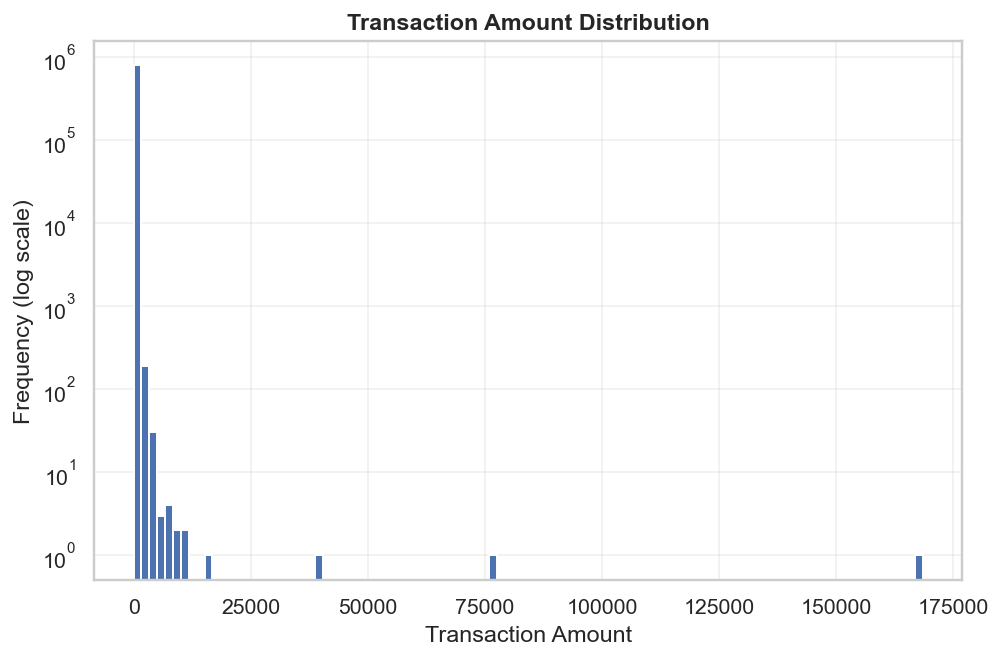

In [50]:
plt.figure(figsize=(8,5))
plt.hist(df_clean['TransactionAmount'], bins=100)
plt.yscale('log')  # Important for visibility
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log scale)')
plt.title('Transaction Amount Distribution')
plt.show()


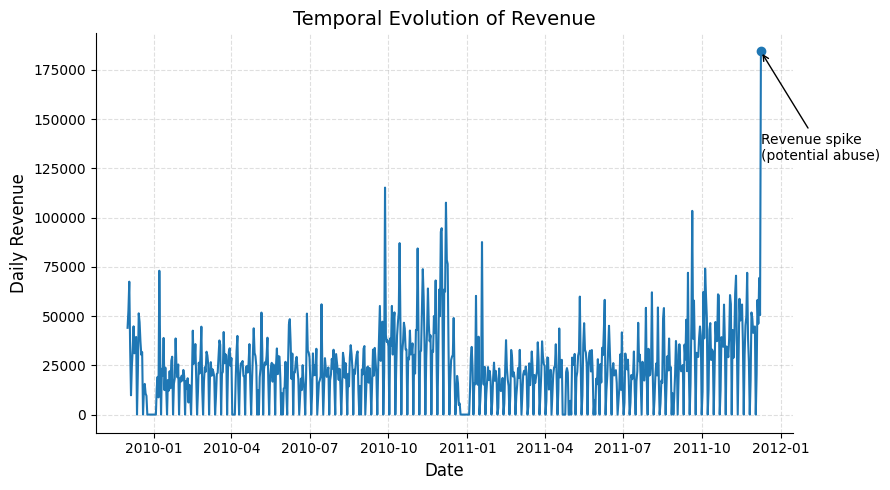

In [43]:
daily_revenue = (
    df_clean
    .set_index('InvoiceDate')
    .resample('D')['TransactionAmount']
    .sum()
)

plt.figure()
plt.plot(daily_revenue)

plt.xlabel("Date")
plt.ylabel("Daily Revenue")
plt.title("Temporal Evolution of Revenue")

# Highlight abnormal peak
peak_date = daily_revenue.idxmax()
peak_value = daily_revenue.max()

plt.scatter(peak_date, peak_value)
plt.annotate(
    "Revenue spike\n(potential abuse)",
    xy=(peak_date, peak_value),
    xytext=(peak_date, peak_value * 0.7),
    arrowprops=dict(arrowstyle="->")
)

plt.tight_layout()
plt.show()


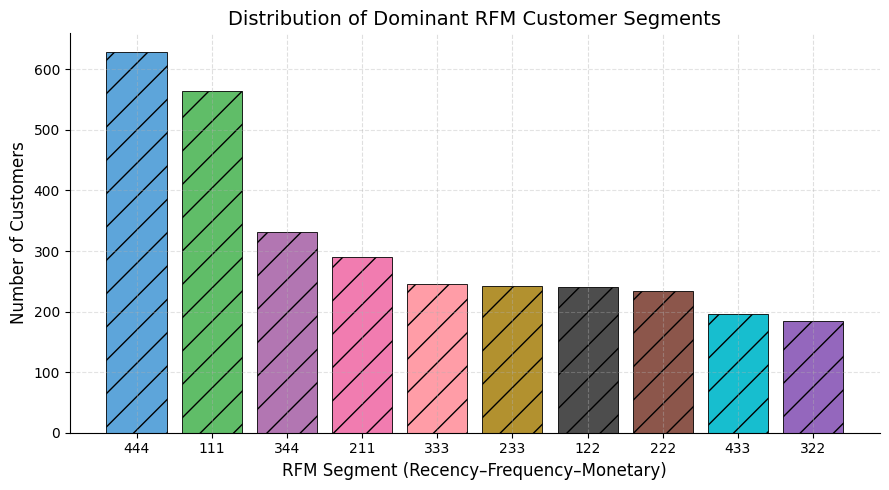

In [37]:
import matplotlib.pyplot as plt

# Prepare data
rfm_counts = rfm['RFM_Segment'].value_counts().head(10)

# Medium-tone professional color palette (balanced contrast)
colors = [
    "#5DA5DA",  # muted blue
    "#60BD68",  # muted green
    "#B276B2",  # muted purple
    "#F17CB0",  # muted pink
    "#FF9DA7",  # muted coral
    "#B2912F",  # muted gold
    "#4D4D4D",  # neutral gray
    "#8C564B",  # muted brown
    "#17BECF",  # muted teal
    "#9467BD"   # muted violet
]

plt.figure(figsize=(9,5))
bars = plt.bar(
    rfm_counts.index,
    rfm_counts.values,
    color=colors,
    edgecolor="black",
    linewidth=0.6
)

# Apply ONLY "/" hatch pattern
for bar in bars:
    bar.set_hatch('/')

# Axis labels and title
plt.xlabel("RFM Segment (Recency–Frequency–Monetary)")
plt.ylabel("Number of Customers")
plt.title("Distribution of Dominant RFM Customer Segments")

# Subtle research-style grid
plt.grid(axis='y', linestyle='--', alpha=0.35)

plt.tight_layout()
plt.show()
